In [165]:
import csv
from pathlib import Path
import matplotlib.pyplot as plot

import nltk

# nltk.download('book')
# nltk.download('brown')

from nltk.corpus import brown
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer

import gensim
from gensim import corpora, models
import numpy as np
np.random.seed(2018)

CROWD_RE_REQUIREMENTS = Path('..', 'crowdre_cleaned-csv', 'requirements.csv')

In [138]:
class Requirement(object):
    def __init__(self, text):
        self.text = text
    
    def tokenize(self):
        self.tokens = nltk.word_tokenize(self.cleaned_text)
    
    def redundant_start(self):
        self.starts_with_smart_home = "I want my smart home to".lower() in self.text.lower()
    
    def remove_stopwords(self):
        self.lexical_words = [word for word in self.tokens if word not in stopwords.words('english')]
        
    def reduce_to_stem(self):
        #lancasterStemmer = LancasterStemmer()
        porterStemmer = PorterStemmer()
        self.stems = []
        for lexicalWord in self.lexical_words:
            self.stems.append(porterStemmer.stem(lexicalWord))
            
    def remove_special_characters(self):
        regexOnlyWords = r'([A-Za-z]*)'
        self.cleaned_text = ' '.join(re.findall(regexOnlyWords,self.text))
        
    def complete_analysis(self):
        self.remove_special_characters()
        self.tokenize()
        self.redundant_start()
        self.remove_stopwords()
        self.reduce_to_stem()
    
    def __str__(self):
        return self.text

In [143]:
class RequirementsList(object):
    def __init__(self, path):
        if not path.exists() and path.is_file():
            raise("The given path does not exist or is not a file.")
        self._build_requirements_list(path)
        self._order_the_tags_list()
    
    def __iter__(self):
        return self.requirements.__iter__() if hasattr(self, 'requirements') else []

    def _build_requirements_list(self, path):
        self.requirements = []
        self.tags = dict()
        self.tagNum = []
        with open(path, newline='') as requirements_csv:
            re_reader = csv.DictReader(requirements_csv, delimiter=',')
            for row in re_reader:
                requirementText = "As a " + row['role'] + " I want " + row['feature'] + " so that " + row['benefit']
                # Get the list of tags
                tagsList = row['tags'].split(",")
                # Remove the whitespaces
                tagsList = [tag.strip(' ') for tag in tagsList]
                # Remove space elements
                tagsList = [tag for tag in tagsList if tag != " "]
                tagsList = [tag for tag in tagsList if tag != ""]
                # Store the counter of tags in a map
                self.tagNum.append(len(tagsList))
                for tag in tagsList:
                    if tag not in self.tags.keys():
                        self.tags[tag] = 1
                    else:
                        self.tags[tag] = self.tags[tag] + 1
                requirement = Requirement(requirementText)
                self.requirements.append(requirement)
                
    def _order_the_tags_list(self):
        orderedDict = dict()
        for key in sorted(self.tags, key=self.tags.get, reverse=True):
            orderedDict[key] = self.tags[key]
        self.tags = orderedDict

    def count(self):
        return len(self.requirements) if hasattr(self, 'requirements') else 0

re_list = RequirementsList(CROWD_RE_REQUIREMENTS)

In [144]:
# NLP analysis
joined_text = " ".join(map(lambda re: re.text, re_list.requirements))
joined_text_tokenized = nltk.word_tokenize(joined_text)

no_of_requirements = re_list.count()
tokens = []
lexical_words = []
stems = []
re_starting_with_smart_home = 0

lexical_words = []

for requirement in re_list:
    requirement.complete_analysis()
    tokens += requirement.tokens    
    lexical_words += requirement.lexical_words
    stems += requirement.stems
    if requirement.starts_with_smart_home:
        re_starting_with_smart_home += 1 

In [92]:
print("Number of Tokens (unique): \t\t{} ({})".format(len(tokens), len(set(tokens))))
print("Number of Lexical Words: \t\t{}".format(len(lexical_words)))

print("\nVocabulary Size (Lexical Words): \t{}".format(len(set(lexical_words))))
print("Vocabulary Size (Stems): \t\t{}".format(len(set(stems))))

print("\nAverage Sentence Length (Tokens): \t{}".format(round(len(tokens) / no_of_requirements)))
print("Average Sentence Length (Lexical Words):{}".format(round(len(lexical_words) / no_of_requirements)))

print("\nLexical Diversity: \t\t\t{}".format(round(len(set(lexical_words)) / len(joined_text),3)))
print("Requirements containing\n\t'...I want my smart home to...': \t{}/{} ({}%)".format(re_starting_with_smart_home, no_of_requirements, round(re_starting_with_smart_home / no_of_requirements * 100, 2)))


Number of Tokens (unique): 		88605 (4812)
Number of Lexical Words: 		49107

Vocabulary Size (Lexical Words): 	4677
Vocabulary Size (Stems): 		3079

Average Sentence Length (Tokens): 	30
Average Sentence Length (Lexical Words):17

Lexical Diversity: 			0.011
Requirements containing
	'...I want my smart home to...': 	416/2966 (14.03%)


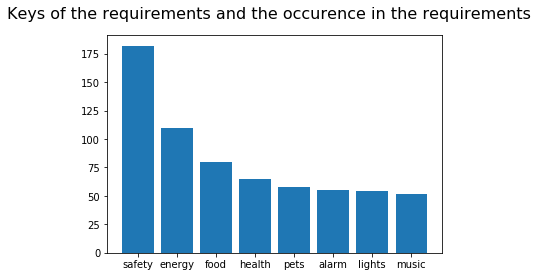

Total amount of keys: 5232
Keys per Requirement: min: 0, avg: 1, max: 11


In [93]:
x = list(re_list.tags.keys())[:8]
y = list(re_list.tags.values())[:8]
plot.bar(x, y)
plot.suptitle("Keys of the requirements and the occurence in the requirements", fontsize=16)
plot.show()
print("Total amount of keys: %d" % sum(re_list.tagNum))
print("Keys per Requirement: min: %d, avg: %d, max: %d" % (min(re_list.tagNum), sum(re_list.tagNum)/len(re_list.tagNum), max(re_list.tagNum)))

In [161]:
# Prepare Dataset for LDA

stemsList = []
for requirement in re_list:
    stemsList.append(requirement.stems)

# Bag of Words on the Data set
dictionary = gensim.corpora.Dictionary(stemsList)

# Gensim doc2bow
bow_corpus = [dictionary.doc2bow(reqirement) for reqirement in stemsList]
bow_doc_2965 = bow_corpus[2965]

for i in range(len(bow_doc_2965)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_2965[i][0], 
                                               dictionary[bow_doc_2965[i][0]], 
bow_doc_2965[i][1]))

Word 0 ("As") appears 1 time.
Word 1 ("I") appears 3 time.
Word 9 ("home") appears 1 time.
Word 16 ("want") appears 1 time.
Word 22 ("hous") appears 1 time.
Word 25 ("occup") appears 1 time.
Word 109 ("time") appears 1 time.
Word 180 ("notifi") appears 1 time.
Word 243 ("potenti") appears 1 time.
Word 340 ("avoid") appears 1 time.
Word 359 ("without") appears 1 time.
Word 375 ("enjoy") appears 1 time.
Word 542 ("moment") appears 1 time.
Word 697 ("alon") appears 2 time.
Word 3078 ("awkward") appears 1 time.
[(2, 0.19555354931137417),
 (3, 0.2556786985075249),
 (4, 0.193936215118777),
 (5, 0.3360157906773499),
 (6, 0.2981277942278957),
 (7, 0.24220481732969915),
 (8, 0.18023486157736918),
 (9, 0.021059853684697004),
 (10, 0.265539734956691),
 (11, 0.2894739369726519),
 (12, 0.26040353992310705),
 (13, 0.3769315792731218),
 (14, 0.0872034462180203),
 (15, 0.20189445973666778),
 (17, 0.20899940817426535),
 (18, 0.3303897255684238)]


In [166]:
# Running LDA using Bag of Words
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=2)
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.095*"I" + 0.054*"As" + 0.052*"want" + 0.036*"home" + 0.019*"door" + 0.019*"lock" + 0.019*"parent" + 0.013*"occup" + 0.011*"owner" + 0.011*"energi"
Topic: 1 
Words: 0.095*"I" + 0.083*"home" + 0.059*"want" + 0.057*"As" + 0.031*"occup" + 0.025*"smart" + 0.018*"owner" + 0.014*"save" + 0.013*"hous" + 0.011*"light"
Topic: 2 
Words: 0.115*"I" + 0.062*"want" + 0.060*"As" + 0.049*"home" + 0.022*"occup" + 0.021*"water" + 0.019*"owner" + 0.013*"smart" + 0.012*"know" + 0.011*"pet"
Topic: 3 
Words: 0.094*"I" + 0.059*"want" + 0.057*"As" + 0.026*"home" + 0.020*"hous" + 0.018*"occup" + 0.012*"get" + 0.011*"parent" + 0.009*"automat" + 0.008*"clean"
Topic: 4 
Words: 0.080*"I" + 0.059*"home" + 0.058*"want" + 0.056*"As" + 0.032*"occup" + 0.013*"smart" + 0.011*"get" + 0.010*"food" + 0.008*"owner" + 0.008*"music"
Topic: 5 
Words: 0.109*"I" + 0.052*"As" + 0.051*"want" + 0.032*"home" + 0.015*"smart" + 0.013*"pet" + 0.012*"owner" + 0.012*"automat" + 0.010*"occup" + 0.009*"music"
Topic: 6 
Wo

In [167]:
# TF-IDF
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# Running LDA using TF-IDF
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
# For each topic, we will explore the words occuring in that topic and its relative weight.
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.007*"occup" + 0.006*"smart" + 0.006*"music" + 0.006*"home" + 0.006*"know" + 0.006*"owner" + 0.006*"hous" + 0.006*"energi" + 0.006*"door" + 0.005*"automat"
Topic: 1 Word: 0.008*"temperatur" + 0.008*"smart" + 0.008*"alert" + 0.006*"home" + 0.006*"occup" + 0.006*"owner" + 0.006*"hous" + 0.005*"adjust" + 0.005*"parent" + 0.005*"child"
Topic: 2 Word: 0.010*"water" + 0.007*"occup" + 0.007*"owner" + 0.007*"open" + 0.006*"smart" + 0.006*"garag" + 0.006*"go" + 0.006*"home" + 0.006*"door" + 0.005*"light"
Topic: 3 Word: 0.007*"occup" + 0.006*"water" + 0.006*"owner" + 0.006*"window" + 0.006*"light" + 0.006*"time" + 0.006*"home" + 0.006*"automat" + 0.006*"heat" + 0.005*"get"
Topic: 4 Word: 0.009*"pet" + 0.006*"owner" + 0.006*"know" + 0.006*"smart" + 0.006*"alert" + 0.006*"occup" + 0.006*"hous" + 0.005*"home" + 0.005*"door" + 0.005*"parent"
Topic: 5 Word: 0.007*"owner" + 0.007*"automat" + 0.007*"occup" + 0.006*"turn" + 0.006*"save" + 0.006*"time" + 0.006*"home" + 0.006*"cook" + 0.00